In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import normalized_mutual_info_score as NMI
import sklearn.datasets as ds

In [195]:
class DPC:
    '''
    基于密度峰值的聚类
    说明：
    1.在代码中没有实现对噪声点的剔除
    2.fit_predict()返回的类别是从1开始编号的
    '''
    def __init__(self, n_cluster, cut_off_dist=None, percent=.02):
        '''
        n_cluster:聚类数
        cut_off_dist:截断距离
        percent:当没有给定cut_off_dist时，由percent确定截断距离
        '''
        self.k = n_cluster
        self.cut_off_dist = cut_off_dist
        self.percent = percent
        
    def get_dist_adj(self, X):
        '''
        计算样本间的距离
        '''
        n = len(X)
        dist_adj = np.zeros((n, n))
        for i in range(n - 1):
            dists = np.linalg.norm(X[i] - X[i+1:], ord=2, axis=1)
            dist_adj[i, i+1:] = dists
        dist_adj = dist_adj + dist_adj.T
        return dist_adj
    
    def get_cutOffDist(self, dist_adj):
        '''
        计算截断距离
        '''
        if self.cut_off_dist != None:
            return self.cut_off_dist
        all_dists = np.array([])
        for i in range(dist_adj.shape[0] - 1):
            all_dists = np.concatenate((all_dists, dist_adj[i, i+1:]))
        all_dists.sort()
        pos = np.around(len(all_dists) * self.percent).astype('int')
        cut_off_dist = all_dists[pos]
        return cut_off_dist
        
    def get_all_density(self, dist_adj, cut_off_dist):
        '''
        计算样本的密度
        '''
        all_density = np.sum(dist_adj < cut_off_dist, axis=1) - 1
        return all_density
        
    def get_all_centDists(self, all_density, dist_adj):
        '''
        计算样本的中心距离
        '''
        n = len(all_density)
        all_centDists = np.zeros(n)
        sort_dens_idx = np.argsort(all_density)[::-1]
        all_centDists[sort_dens_idx[0]] = dist_adj[sort_dens_idx[0]].max()
        for i in range(1, n):
            valid_idx = sort_dens_idx[: i]
            all_centDists[sort_dens_idx[i]] = dist_adj[sort_dens_idx[i]][valid_idx].min()
        return all_centDists
    
    def show_DecisionGraph(self):
        '''
        绘制决策图
        '''
        plt.scatter(self.all_centDists, self.all_density)
        plt.xlabel('ρ')
        plt.ylabel('σ')
        plt.show()
        
    def get_cluster_center(self, all_density, all_centDists):
        '''
        选取聚类中心
        '''
        scale_density = (all_density - all_density.min()) / (all_density.max() - all_density.min())
        scale_centDists = (all_centDists - all_centDists.min()) / (all_centDists.max() - all_centDists.min())
        dens_cent = scale_centDists * scale_density
        centers = np.argsort(dens_cent)[-self.k:]
        return centers
    
    def fit_predict(self, X):
        dist_adj = self.get_dist_adj(X)
        cut_off_dist = self.get_cutOffDist(dist_adj)
        all_density = self.get_all_density(dist_adj, cut_off_dist)
        all_centDists = self.get_all_centDists(all_density, dist_adj)
        centers = self.get_cluster_center(all_density, all_centDists)
        self.all_density = all_density
        self.all_centDists = all_centDists
        labels = np.zeros(X.shape[0], dtype='int')
        for i in range(self.k):
            labels[centers[i]] = i + 1
        sort_dens_idx = np.argsort(all_density)[::-1]
        for i in range(X.shape[0]):
            idx = sort_dens_idx[i]
            if idx in centers:
                continue
            valid_idx = sort_dens_idx[:i]
            dists = dist_adj[idx, valid_idx]
            i_min = np.argmin(dists)
            labels[idx] = labels[sort_dens_idx[i_min]]
        return labels

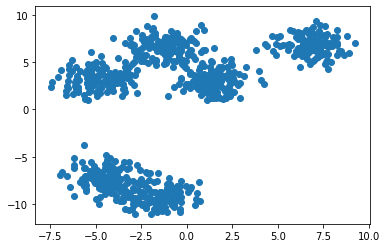

In [198]:
# 生成数据
data, tar = ds.make_blobs(800, n_features=2, centers=6)
plt.scatter(data[:, 0], data[:, 1])

In [202]:
# 预测
dpc = DPC(n_cluster=6)
pred = dpc.fit_predict(data)
pred

array([1, 1, 5, 3, 5, 6, 6, 5, 3, 5, 1, 6, 3, 5, 5, 3, 5, 3, 2, 2, 2, 3,
       5, 3, 6, 6, 1, 1, 5, 2, 1, 2, 1, 1, 6, 3, 5, 4, 6, 2, 1, 4, 5, 3,
       5, 5, 6, 4, 6, 2, 6, 3, 6, 3, 5, 3, 1, 1, 6, 5, 4, 3, 5, 5, 5, 3,
       5, 4, 5, 5, 1, 1, 5, 3, 4, 1, 3, 2, 5, 6, 6, 6, 2, 2, 4, 4, 6, 1,
       6, 4, 1, 6, 2, 6, 6, 1, 5, 1, 2, 5, 5, 3, 1, 4, 5, 2, 4, 2, 5, 2,
       4, 6, 4, 3, 6, 4, 5, 1, 1, 5, 2, 5, 1, 4, 5, 5, 1, 5, 3, 3, 6, 5,
       3, 5, 5, 3, 4, 6, 3, 6, 4, 1, 6, 5, 4, 4, 6, 6, 4, 2, 4, 1, 6, 6,
       5, 4, 4, 4, 4, 3, 4, 6, 5, 4, 2, 1, 4, 1, 6, 5, 6, 2, 6, 2, 5, 3,
       1, 5, 3, 2, 5, 2, 4, 6, 5, 6, 4, 6, 5, 1, 6, 5, 4, 6, 6, 1, 4, 4,
       6, 3, 5, 1, 1, 4, 6, 6, 1, 3, 5, 3, 5, 4, 1, 5, 1, 4, 5, 4, 3, 5,
       6, 1, 5, 1, 4, 4, 1, 3, 5, 2, 4, 4, 1, 5, 5, 4, 5, 4, 3, 3, 2, 1,
       5, 3, 2, 5, 6, 1, 6, 6, 6, 2, 4, 3, 5, 4, 5, 3, 4, 6, 4, 6, 5, 6,
       6, 6, 1, 6, 6, 6, 2, 3, 5, 1, 2, 5, 5, 3, 5, 1, 4, 5, 6, 1, 3, 3,
       6, 4, 5, 1, 1, 1, 6, 6, 6, 6, 1, 3, 5, 5, 4,

In [200]:
tar += 1
tar

array([1, 1, 3, 5, 3, 6, 6, 3, 5, 3, 1, 6, 5, 3, 3, 5, 3, 5, 4, 4, 4, 5,
       4, 5, 6, 6, 1, 1, 3, 4, 1, 4, 1, 1, 6, 5, 4, 2, 6, 4, 1, 2, 3, 5,
       4, 3, 6, 2, 6, 4, 6, 5, 6, 5, 3, 5, 1, 1, 6, 3, 2, 5, 3, 3, 3, 5,
       4, 2, 3, 4, 1, 1, 3, 5, 2, 1, 5, 4, 4, 6, 6, 6, 4, 4, 2, 2, 6, 1,
       6, 2, 1, 6, 4, 6, 6, 1, 3, 1, 4, 3, 4, 5, 1, 2, 4, 4, 2, 4, 3, 4,
       2, 6, 2, 5, 6, 2, 3, 1, 1, 3, 4, 3, 5, 2, 3, 4, 1, 4, 5, 5, 6, 3,
       5, 3, 3, 5, 2, 6, 5, 6, 2, 1, 6, 3, 2, 2, 6, 6, 2, 4, 2, 1, 6, 6,
       3, 2, 2, 2, 2, 5, 2, 6, 3, 2, 4, 1, 2, 1, 6, 4, 6, 4, 6, 4, 4, 5,
       1, 3, 5, 4, 3, 4, 2, 6, 3, 6, 2, 6, 3, 1, 6, 3, 2, 6, 6, 1, 2, 2,
       6, 5, 3, 1, 1, 2, 6, 6, 1, 5, 4, 5, 3, 2, 1, 3, 1, 2, 3, 2, 5, 3,
       6, 1, 3, 1, 2, 2, 1, 5, 3, 4, 2, 2, 1, 3, 4, 2, 3, 2, 5, 5, 4, 1,
       4, 5, 4, 4, 6, 1, 6, 6, 6, 4, 2, 5, 3, 2, 3, 5, 2, 6, 2, 6, 3, 6,
       6, 6, 1, 6, 6, 6, 4, 5, 3, 1, 4, 3, 3, 5, 3, 1, 2, 3, 6, 1, 5, 5,
       6, 2, 3, 1, 1, 1, 6, 6, 6, 6, 1, 5, 3, 3, 2,

In [203]:
# 精度
NMI(tar, pred)

0.9164158792323935

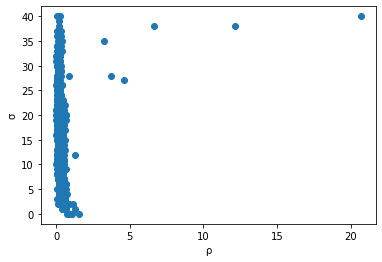

In [204]:
# 决策图
dpc.show_DecisionGraph()

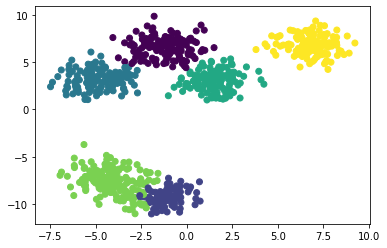

In [205]:
# 聚类可视化结果
plt.scatter(data[:, 0], data[:, 1], c=pred)